# Implementation of search algorithms and search problems.
# Complete $A^*$ search (`astar_search` function below): 10 points

In [1]:
import random, math, sys, heapq
from collections import defaultdict, deque, Counter
from itertools import combinations

import matplotlib.pyplot as plt
%matplotlib inline

## Problems

We start by defining the abstract class for a `Problem`; specific problem domains will subclass this. 

To make it easier for algorithms that use a heuristic evaluation function, `Problem` has a default `h` function (uniformly zero), and subclasses can define their own default `h` function. 

In [2]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass.
    
    The default heuristic is 0 and the default action cost is 1 for all states.
    """

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
        
    def actions(self, state):        
        raise NotImplementedError
        
    def result(self, state, action): 
        raise NotImplementedError
        
    def is_goal(self, state):        
        return state == self.goal
    
    def action_cost(self, s, a, s1): 
        return 1
    
    def h(self, node):               
        return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

## Nodes
We also define a `Node` in a search tree, and some functions on nodes: `expand` to generate successors; `path_actions` and `path_states`  to recover aspects of the path from the node. 

In [3]:
class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)
        
    def __lt__(self, other): 
        return self.path_cost < other.path_cost

    def __repr__(self): 
        return '<{}>'.format(self.state)
    
    def __len__(self): 
        return 0 if self.parent is None else (1 + len(self.parent))

def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)    

def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []  
    return path_actions(node.parent) + [node.action]

failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.

def path_states(node, failure=failure, cutoff=cutoff):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): 
        return []
    return path_states(node.parent) + [node.state]

## PriorityQueue

`PriorityQueue` is a class that allows you to keep a collection of items, and continually remove from it the item with minimum score.

In [4]:
class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""
    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) or (key, value) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queue."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): 
        return self.items[0][1]

    def __len__(self): 
        return len(self.items)

## Search Algorithms: Best-First, $A^*$, weighted $A^*$

Best-first search with various *f(n)* functions gives us different search algorithms. Note that A\*, weighted A\* and greedy search can be given a heuristic function, `h`, but if `h` is not supplied they use the problem's default `h` function (if the problem does not define one, it is taken as *h(n)* = 0).

### Complete `astar_search` function below (10 points)

In [5]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def g(node): 
    return node.path_cost

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    ############################Write your code here########################################################
    # Hint: only a single line is needed; very similar to the last line of weighted_astar_search (10 points)
    
    ############################End code####################################################################
    return best_first_search(problem, f=lambda n: g(n) + h(n))

def weighted_astar_search(problem, h=None, weight=1.4):
    """Search nodes with minimum f(n) = g(n) + weight * h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + weight * h(n))

## Problem Domains

Now we turn our attention to defining some problem domains as subclasses of `Problem`.

### Route Finding Problems

In a `RouteProblem`, the states are names of "cities" (or other locations), like `'A'` for Arad. The actions are also city names; `'Z'` is the action to move to city `'Z'`. The layout of cities is given by a separate data structure, a `Map`, which is a graph where there are vertexes (cities), links between vertexes, distances (costs) of those links (if not specified, the default is 1 for every link), and optionally the 2D (x, y) location of each city can be specified. A `RouteProblem` takes this `Map` as input and allows actions to move between linked cities. The default heuristic is straight-line distance to the goal, or is uniformly zero if locations were not given.

In [6]:
class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""
    
    def actions(self, state): 
        """The places neighboring `state`."""
        return self.map.neighbors[state]
    
    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state
    
    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]
    
    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return straight_line_distance(locs[node.state], locs[self.goal])
    
def straight_line_distance(A, B):
    "Straight-line distance between two points."
    return sum(abs(a - b)**2 for (a, b) in zip(A, B)) ** 0.5

In [7]:
class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them. 
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs, 
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)} 
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))

def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list)
    for key, val in pairs:
        result[key].append(val)
    return result

In [8]:
# Some specific RouteProblems

vertices = {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294), 
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)}

edges = {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118, 
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146, 
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101, 
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142, 
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97}

vertex_names = sorted(vertices)
edge_names = sorted(edges)

!pip install python-igraph

import igraph
graph = igraph.Graph()
graph.add_vertices(len(vertices), attributes={'name': vertex_names, 'location': [vertices[v] for v in vertex_names]})
graph.add_edges(edge_names, attributes={'distance': [edges[e] for e in edge_names]})

     |████████████████████████████████| 2.1 MB 4.3 MB/s eta 0:00:01
  Created wheel for python-igraph: filename=python_igraph-0.10.2-py3-none-any.whl size=9074 sha256=03b02a4989a71a03970beb54356960194f6ddc1c97eab1309b3a0b3bacf1c0c1
  Stored in directory: /Users/ayomide/Library/Caches/pip/wheels/4c/35/1d/11bb895ade10b4da7d78b77b3ed81b10155d6b450c74f83647
Successfully built python-igraph


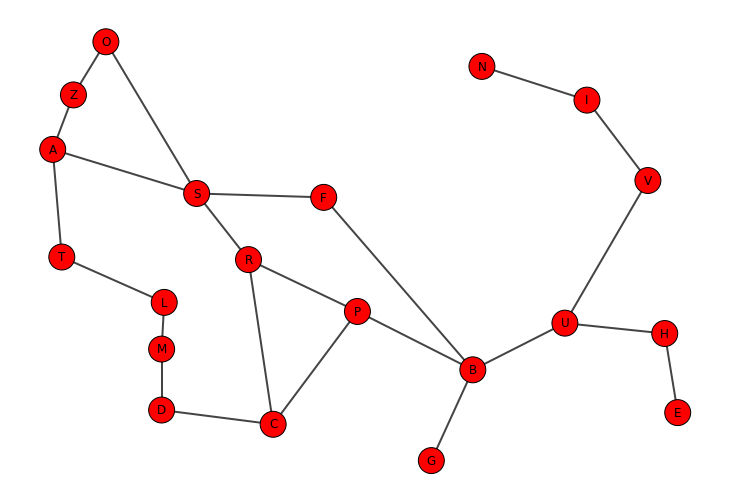

In [9]:
import matplotlib.pyplot as plt
visual_style = {}
visual_style["layout"] = igraph.Layout(graph.vs['location'])
visual_style["vertex_size"] = 20
visual_style["vertex_label"] = graph.vs["name"]
visual_style["bbox"] = (300, 300)
visual_style["margin"] = 20
fig, ax = plt.subplots(figsize=(16, 9))
igraph.plot(graph, target=ax, **visual_style)
plt.show()

In [10]:
romania = Map(edges, vertices)
r1 = RouteProblem('A', 'B', map=romania)
r2 = RouteProblem('N', 'L', map=romania)
r3 = RouteProblem('E', 'T', map=romania)
r4 = RouteProblem('O', 'M', map=romania)

## Use $A^*$ or weighted $A^*$ to find the best solutions to r1, r2, r3, r4

In [17]:
solution = path_states(astar_search(r1))
cost = [edges[(solution[i-1], solution[i])] for i in range(1, len(solution))]
print(solution)
print(cost)
print(sum(cost))

['E', 'H', 'U', 'B', 'P', 'R', 'S', 'A', 'T']
[86, 98, 85, 101, 97, 80, 140, 118]
805


In [16]:
solution = path_states(weighted_astar_search(r3, weight=2))
cost = [edges[(solution[i-1], solution[i])] for i in range(1, len(solution))]
print(solution)
print(cost)
print(sum(cost))

['E', 'H', 'U', 'B', 'P', 'R', 'S', 'A', 'T']
[86, 98, 85, 101, 97, 80, 140, 118]
805
